All libraries imported successfully!
=== Checking Dataset Structure ===

--- Training Dataset Check ---
Found 2870 image files
First 5 files:
  1. gg (1).jpg
     ✓ Readable - Shape: (512, 512, 3)
  2. gg (10).jpg
     ✓ Readable - Shape: (512, 512, 3)
  3. gg (100).jpg
     ✓ Readable - Shape: (512, 512, 3)
  4. gg (101).jpg
     ✓ Readable - Shape: (512, 512, 3)
  5. gg (102).jpg
     ✓ Readable - Shape: (512, 512, 3)

--- Testing Dataset Check ---
Found 394 image files
First 5 files:
  1. image(1).jpg
     ✓ Readable - Shape: (619, 495, 3)
  2. image(10).jpg
     ✓ Readable - Shape: (406, 386, 3)
  3. image(100).jpg
     ✓ Readable - Shape: (419, 369, 3)
  4. image(11).jpg
     ✓ Readable - Shape: (581, 524, 3)
  5. image(12).jpg
     ✓ Readable - Shape: (581, 524, 3)

=== Medical Image Real/Fake Detection System ===
Training path: C:\Users\geeth\OneDrive\Desktop\Project\archive\Training
Testing path: C:\Users\geeth\OneDrive\Desktop\Project\archive\Testing
=== Starting Training Proc

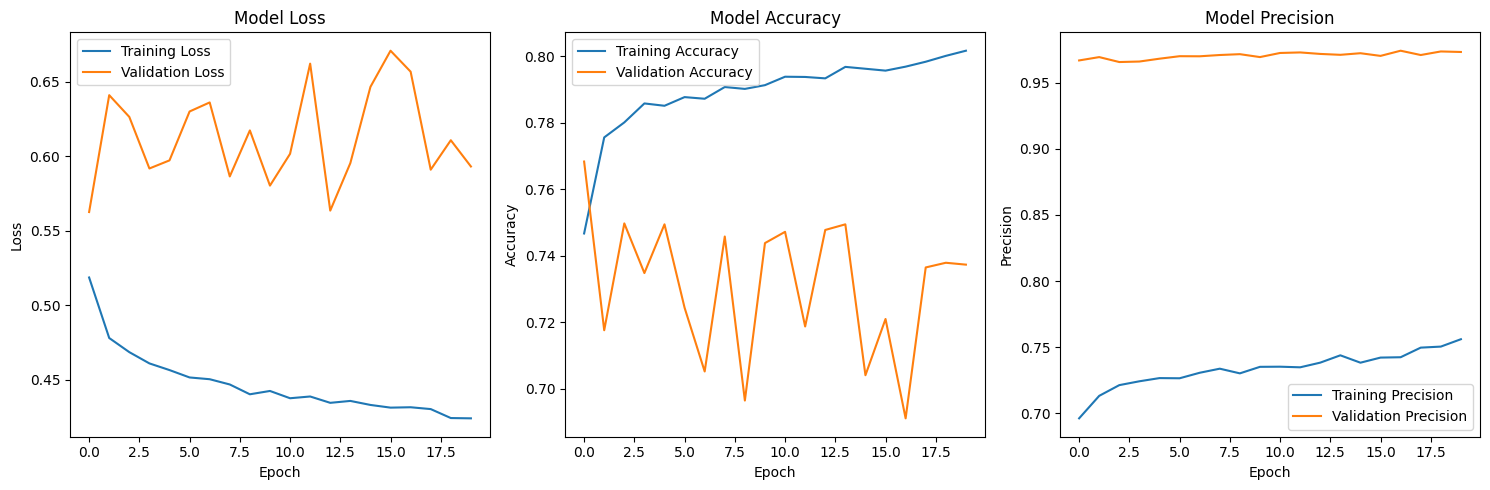


=== Model Evaluation on Test Data ===
Loading and extracting features from images...
Processed 10 images...
Processed 20 images...
Processed 30 images...
Processed 40 images...
Processed 50 images...
Processed 60 images...
Processed 70 images...
Processed 80 images...
Processed 90 images...
Processed 100 images...
Processed 110 images...
Processed 120 images...
Processed 130 images...
Processed 140 images...
Processed 150 images...
Processed 160 images...
Processed 170 images...
Processed 180 images...
Processed 190 images...
Processed 200 images...
Processed 210 images...
Processed 220 images...
Processed 230 images...
Processed 240 images...
Processed 250 images...
Processed 260 images...
Processed 270 images...
Processed 280 images...


In [ ]:
# COMPLETE FIXED CODE WITH UPDATED PATHS AND BETTER ERROR HANDLING
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from ctgan import CTGAN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

class MedicalImageBiasDetector:
    def __init__(self, image_size=(128, 128)):
        self.image_size = image_size
        self.scaler = StandardScaler()
        self.model = None
        self.ctgan = None
        
    def extract_image_features(self, image_path):
        """Extract comprehensive features from medical images"""
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Could not read image {image_path}")
                return None
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            
            features = []
            
            # 1. Basic color features
            mean_color = np.mean(image, axis=(0, 1))
            std_color = np.std(image, axis=(0, 1))
            features.extend(mean_color)
            features.extend(std_color)
            
            # 2. Texture features
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
            # Gradient features
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
            features.extend([np.mean(gradient_magnitude), np.std(gradient_magnitude)])
            
            # 3. Statistical features
            features.append(np.mean(gray))
            features.append(np.std(gray))
            features.append(np.median(gray))
            
            # 4. Edge density
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
            features.append(edge_density)
            
            # 5. Frequency domain features
            fft = np.fft.fft2(gray)
            fft_shift = np.fft.fftshift(fft)
            magnitude_spectrum = np.log(np.abs(fft_shift) + 1)
            features.extend([np.mean(magnitude_spectrum), np.std(magnitude_spectrum)])
            
            return np.array(features)
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None
    
    def create_synthetic_images_via_augmentation(self, image_path, num_synthetic=5):
        """Create synthetic images using data augmentation"""
        try:
            image = cv2.imread(image_path)
            if image is None:
                return []
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            synthetic_images = []
            
            # Define augmentations
            augmentations = [
                lambda img: cv2.GaussianBlur(img, (3, 3), 0),
                lambda img: cv2.addWeighted(img, 1.2, np.zeros_like(img), 0, 20),  # Brightness
                lambda img: cv2.addWeighted(img, 0.8, np.zeros_like(img), 0, 0),   # Darkness
                lambda img: cv2.flip(img, 1),  # Horizontal flip
                lambda img: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
            ]
            
            for i in range(num_synthetic):
                aug_img = augmentations[i % len(augmentations)](image)
                synthetic_images.append(aug_img)
                
            return synthetic_images
        except Exception as e:
            print(f"Error in augmentation: {e}")
            return []
    
    def load_dataset_with_synthetic(self, real_images_path, num_synthetic_per_image=2):
        """Load real images and create synthetic ones for binary classification"""
        print("Loading and extracting features from images...")
        
        X = []
        y = []
        
        # Load real images - handle subdirectories
        real_count = 0
        processed_count = 0
        
        if os.path.exists(real_images_path):
            # Walk through all subdirectories
            for root, dirs, files in os.walk(real_images_path):
                for filename in files:
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
                        filepath = os.path.join(root, filename)
                        features = self.extract_image_features(filepath)
                        if features is not None:
                            X.append(features)
                            y.append(1)  # 1 for real images
                            real_count += 1
                            processed_count += 1
                            
                            # Create synthetic versions of this image
                            synthetic_imgs = self.create_synthetic_images_via_augmentation(
                                filepath, num_synthetic_per_image
                            )
                            
                            for synth_img in synthetic_imgs:
                                # Extract features from synthetic image
                                try:
                                    # Convert back to proper format for feature extraction
                                    synth_img_resized = cv2.resize(synth_img, self.image_size)
                                    
                                    # Manually extract features similar to extract_image_features
                                    synth_features = []
                                    
                                    # Color features
                                    mean_color = np.mean(synth_img_resized, axis=(0, 1))
                                    std_color = np.std(synth_img_resized, axis=(0, 1))
                                    synth_features.extend(mean_color)
                                    synth_features.extend(std_color)
                                    
                                    # Texture features
                                    gray = cv2.cvtColor(synth_img_resized, cv2.COLOR_RGB2GRAY)
                                    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
                                    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
                                    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
                                    synth_features.extend([np.mean(gradient_magnitude), np.std(gradient_magnitude)])
                                    
                                    # Statistical features
                                    synth_features.extend([np.mean(gray), np.std(gray), np.median(gray)])
                                    
                                    # Edge density
                                    edges = cv2.Canny(gray, 50, 150)
                                    edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
                                    synth_features.append(edge_density)
                                    
                                    # Frequency domain features
                                    fft = np.fft.fft2(gray)
                                    fft_shift = np.fft.fftshift(fft)
                                    magnitude_spectrum = np.log(np.abs(fft_shift) + 1)
                                    synth_features.extend([np.mean(magnitude_spectrum), np.std(magnitude_spectrum)])
                                    
                                    X.append(np.array(synth_features))
                                    y.append(0)  # 0 for synthetic images
                                    processed_count += 1
                                    
                                except Exception as e:
                                    print(f"Error processing synthetic image: {e}")
                                    continue
                        
                        # Progress reporting
                        if processed_count % 10 == 0:
                            print(f"Processed {processed_count} images...")
        
        # Convert to numpy arrays safely
        if len(X) > 0:
            X = np.array(X)
            y = np.array(y)
            print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
        else:
            X = np.array([])
            y = np.array([])
            print("Dataset loaded: 0 samples")
        
        print(f"Real images: {np.sum(y==1) if len(y) > 0 else 0}, Synthetic images: {np.sum(y==0) if len(y) > 0 else 0}")
        
        return X, y
    
    def reduce_bias_smote(self, X, y):
        """Apply SMOTE to reduce bias and balance classes - only if we have multiple classes"""
        print("Applying SMOTE for bias reduction...")
        
        unique, counts = np.unique(y, return_counts=True)
        print(f"Before processing - Class distribution: {dict(zip(unique, counts))}")
        
        # Only apply SMOTE if we have at least 2 classes
        if len(unique) < 2:
            print("Only one class found. Cannot apply SMOTE. Using original data.")
            return X, y
        
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        unique, counts = np.unique(y_resampled, return_counts=True)
        print(f"After SMOTE - Class distribution: {dict(zip(unique, counts))}")
        
        return X_resampled, y_resampled
    
    def generate_synthetic_data_ctgan(self, X, y, num_synthetic_samples=500):
        """Generate synthetic data using CTGAN - only if we have enough data"""
        if len(X) < 10:
            print("Not enough data for CTGAN. Using basic augmentation instead.")
            return X, y
            
        print("Generating synthetic data using CTGAN...")
        
        try:
            feature_columns = [f'feature_{i}' for i in range(X.shape[1])]
            data = pd.DataFrame(X, columns=feature_columns)
            data['label'] = y
            
            self.ctgan = CTGAN(epochs=50)
            self.ctgan.fit(data, ['label'])
            
            synthetic_data = self.ctgan.sample(num_synthetic_samples)
            
            X_synthetic = synthetic_data[feature_columns].values
            y_synthetic = synthetic_data['label'].values
            
            print(f"Generated {len(X_synthetic)} synthetic samples")
            
            return X_synthetic, y_synthetic
        except Exception as e:
            print(f"CTGAN failed: {e}. Using original data.")
            return X, y
    
    def build_detection_model(self, input_dim):
        """Build a deep learning model for real/fake detection"""
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model
    
    def train_detector(self, train_path, test_path, use_smote=True, use_ctgan=True):
        """Train the real/fake image detector"""
        
        print("=== Starting Training Process ===")
        
        # Load training data with synthetic images
        X_train, y_train = self.load_dataset_with_synthetic(train_path, num_synthetic_per_image=3)
        
        # Check if we have enough data
        if len(X_train) == 0:
            print("No training data found! Please check your dataset path and file formats.")
            print("Supported formats: PNG, JPG, JPEG, TIFF, BMP")
            return None
            
        print(f"Training data shape: {X_train.shape}")
        
        # Apply bias reduction techniques only if we have multiple classes
        if use_smote and len(np.unique(y_train)) > 1:
            X_train, y_train = self.reduce_bias_smote(X_train, y_train)
        else:
            print("Skipping SMOTE - not enough classes")
        
        # Generate additional synthetic data if requested
        if use_ctgan and len(X_train) > 10 and len(np.unique(y_train)) > 1:
            X_synthetic, y_synthetic = self.generate_synthetic_data_ctgan(X_train, y_train)
            X_train = np.vstack([X_train, X_synthetic])
            y_train = np.hstack([y_train, y_synthetic])
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Build and train model
        self.model = self.build_detection_model(X_train_scaled.shape[1])
        
        print("Training the detection model...")
        history = self.model.fit(
            X_train_scaled, y_train,
            epochs=20,  # Reduced for faster training
            batch_size=16,
            validation_split=0.2,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        if 'precision' in history.history:
            plt.subplot(1, 3, 3)
            plt.plot(history.history['precision'], label='Training Precision')
            plt.plot(history.history['val_precision'], label='Validation Precision')
            plt.title('Model Precision')
            plt.xlabel('Epoch')
            plt.ylabel('Precision')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Evaluate on test data
        if test_path and os.path.exists(test_path):
            self.evaluate_model(test_path)
        
        return history
    
    def evaluate_model(self, test_path):
        """Evaluate the model on test data"""
        print("\n=== Model Evaluation on Test Data ===")
        
        # Load test data with synthetic versions
        X_test, y_test = self.load_dataset_with_synthetic(test_path, num_synthetic_per_image=1)
        
        if len(X_test) == 0:
            print("No test images found!")
            return
        
        X_test_scaled = self.scaler.transform(X_test)
        
        if self.model:
            y_pred_prob = self.model.predict(X_test_scaled)
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=['Synthetic', 'Real']))
            
            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Synthetic', 'Real'], 
                       yticklabels=['Synthetic', 'Real'])
            plt.title('Confusion Matrix - Real vs Synthetic Detection')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
    
    def predict_single_image(self, image_path):
        """Predict if a single image is real or synthetic"""
        if self.model is None:
            return {"prediction": "Error: Model not trained yet", "confidence": 0.0, "raw_score": 0.0}
        
        features = self.extract_image_features(image_path)
        if features is None:
            return {"prediction": "Error: Could not process image", "confidence": 0.0, "raw_score": 0.0}
        
        features_scaled = self.scaler.transform([features])
        prediction_prob = self.model.predict(features_scaled, verbose=0)[0][0]
        prediction = "REAL" if prediction_prob > 0.5 else "SYNTHETIC"
        confidence = prediction_prob if prediction_prob > 0.5 else 1 - prediction_prob
        
        return {
            'prediction': prediction,
            'confidence': float(confidence),
            'raw_score': float(prediction_prob)
        }

# ===== MAIN EXECUTION =====
# First, let's check what's in your dataset
print("=== Checking Dataset Structure ===")
train_path = r"C:\Users\geeth\OneDrive\Desktop\Project\archive\Training"
test_path = r"C:\Users\geeth\OneDrive\Desktop\Project\archive\Testing"

def check_dataset(path, name):
    print(f"\n--- {name} Dataset Check ---")
    if not os.path.exists(path):
        print(f"❌ Path does not exist: {path}")
        return 0
    
    image_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.dcm')
    image_files = []
    
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_files.append(os.path.join(root, file))
    
    print(f"Found {len(image_files)} image files")
    
    # Show first few files
    if image_files:
        print("First 5 files:")
        for i, file_path in enumerate(image_files[:5]):
            print(f"  {i+1}. {os.path.basename(file_path)}")
            
            # Check if file can be read
            try:
                img = cv2.imread(file_path)
                if img is not None:
                    print(f"     ✓ Readable - Shape: {img.shape}")
                else:
                    print(f"     ✗ Cannot read file")
            except Exception as e:
                print(f"     ✗ Error reading: {e}")
    else:
        print("No image files found!")
        print(f"Contents of directory: {os.listdir(path)}")
    
    return len(image_files)

# Check both datasets
train_count = check_dataset(train_path, "Training")
test_count = check_dataset(test_path, "Testing")

# Only proceed if we have training data
if train_count > 0:
    # Initialize detector
    detector = MedicalImageBiasDetector(image_size=(128, 128))

    print("\n=== Medical Image Real/Fake Detection System ===")
    print(f"Training path: {train_path}")
    print(f"Testing path: {test_path}")

    # Train the detector
    history = detector.train_detector(
        train_path=train_path,
        test_path=test_path,
        use_smote=True,
        use_ctgan=True
    )
    
    if history is not None:
        # Test on sample images
        print("\n=== Testing on Sample Images ===")
        if os.path.exists(test_path):
            test_files = []
            for root, dirs, files in os.walk(test_path):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        test_files.append(os.path.join(root, file))
            
            if test_files:
                # Test on first 3 images
                for i, test_image_path in enumerate(test_files[:3]):
                    print(f"\n--- Testing Image {i+1}: {os.path.basename(test_image_path)} ---")
                    
                    result = detector.predict_single_image(test_image_path)
                    print(f"Prediction: {result['prediction']}")
                    print(f"Confidence: {result['confidence']:.4f}")
                    print(f"Raw Score: {result['raw_score']:.4f}")
                    
                    # Display the image
                    try:
                        img = cv2.imread(test_image_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            plt.figure(figsize=(6, 4))
                            plt.imshow(img)
                            plt.title(f"Image: {os.path.basename(test_image_path)}\nPrediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
                            plt.axis('off')
                            plt.show()
                        else:
                            print(f"Could not load image: {test_image_path}")
                    except Exception as e:
                        print(f"Could not display image: {e}")
            else:
                print("No test images found in the test directory!")
        
        print("\n=== Training and Evaluation Complete ===")
        print("The model can now distinguish between real and AI-generated medical images!")

        # ===== ADDITIONAL ANALYSIS =====
        print("\n" + "="*50)
        print("ADDITIONAL ANALYSIS")
        print("="*50)

        # Check model summary
        if detector.model:
            print("Model trained successfully!")
            detector.model.summary()
else:
    print("\n❌ Cannot proceed - no training images found!")
    print("Please check:")
    print("1. The path is correct")
    print("2. The directory contains image files (PNG, JPG, JPEG, TIFF, BMP)")
    print("3. You have read permissions for the directory")